# XGBoost Classifier

### 1. Module Import
***

In [11]:
import xgboost as xgb
import pandas as pd
import numpy as np
import Classification.config as cfg
import csv
import nltk
import re
import random
import warnings
import spacy
import pickle
import time
from nltk.util import ngrams
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


### 2.1 Defining the string cleaner

In [2]:
def clean(string):
    #return string
    clean_string = string.replace(u'\xa0', u' ')
    clean_string = re.sub(r'\d+', ' number ', clean_string)
    clean_string = re.sub(r'Ä', 'Ae', clean_string)
    clean_string = re.sub(r'ä', 'ae', clean_string)
    clean_string = re.sub(r'Ö', 'Oe', clean_string)
    clean_string = re.sub(r'ö', 'oe', clean_string)
    clean_string = re.sub(r'Ü', 'Ue', clean_string)
    clean_string = re.sub(r'ü', 'ue', clean_string)
    clean_string = re.sub(r'ß', 'ss', clean_string)
    clean_string = re.sub(r'°', ' Grad ', clean_string)
    clean_string = re.sub(r'/', ' oder ', clean_string)
    clean_string = re.sub(r'%', ' Prozent ', clean_string)
    clean_string = re.sub(r'[Zz][Bb]', 'zum Beispiel', clean_string)
    clean_string = re.sub(r'[Dd][Hh]', 'das heißt', clean_string)
    clean_string = re.sub(r'[Bb][Ss][Pp][Ww]', 'beispielsweise', clean_string)
    clean_string = re.sub(r'[Hh]allo', '', clean_string)
    clean_string = re.sub(r'[Hh]i', '', clean_string)
    clean_string = re.sub(r'[Hh]ey', '', clean_string)
    clean_string = re.sub(r'[Gg]uten\s[Mm]orgen', '', clean_string)
    clean_string = re.sub(r'[Gg]uten\s[Aa]bend', '', clean_string)
    
    clean_string = re.sub(r'(\([^)]*\))', ' ', clean_string)
    clean_string = re.sub(r'"', '', clean_string)
    clean_string = re.sub(r'\+', '', clean_string)
    clean_string = re.sub(r'-', '', clean_string)
    clean_string = re.sub(r',', '', clean_string)
    clean_string = re.sub(r'\^', '', clean_string)
    clean_string = re.sub(r'\'', '', clean_string)
    clean_string = re.sub(r'`', '', clean_string)
    clean_string = re.sub(r'´', '', clean_string)


    clean_string = re.sub(r'\'', '', clean_string)
    clean_string = re.sub(r'\.', '', clean_string)
    clean_string = re.sub(r'\s{2,}', ' ', clean_string)
    clean_string = re.sub(r'\s(?=\?)', ' ', clean_string)
    clean_string = re.sub(r'\?*(?=(?:\?))', '', clean_string)
    clean_string = clean_string.strip()
    #bitte, danke, und, eigentlich, überhaupt, git, wirklich
    return clean_string#.lower()


### 2.2 Building the lemmatizer

In [3]:
nlp = spacy.load('de')

def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)


### 3.1 Importing the dataset

In [4]:
data_set = []
for i, file in enumerate(cfg.ALL_FILES):
    file_count = len(cfg.ALL_FILES)
    reader = csv.reader(open(file, 'r'), delimiter=';')
    for line in reader:
        try:
            data_set.append([lemmatizer(clean(line[0])).lower(), line[1]])
        except Exception as e:
            print(e)
    print(('({0}/{1} Imported file {2}. Total length: {3})'.format(i + 1, file_count, file, len(data_set))), end='\r')
print('\n\nImport finished. Total length of data set: {}'.format(len(data_set)))
data_set_frame = pd.DataFrame(data_set, columns =['Feature', 'Label'])

(30/30 Imported file C:\Users\Josef\PycharmProjects\QC-Yes-No\Corpus\Tweets\data\output_1000_tweets_2018-09-22_17-18-48\classified.csv. Total length: 5012)

Import finished. Total length of data set: 5012



### 3.2 Creating PosTag feature

In [5]:
with open('Classification\\nltk_german_classifier_data.pickle', 'rb') as f:
    tagger = pickle.load(f)
    
data_set_frame['PosTags'] = ''
for i, line in enumerate(data_set_frame['Feature']):
    sent = nltk.tokenize.WordPunctTokenizer().tokenize(line)
    tag_line = []
    for tag in tagger.tag(sent):
        tag_line.append(tag[1])
    data_set_frame.at[i, 'PosTags'] = tag_line
    print(('Tagged line {}'.format(i)), end='\r')

In [14]:
start = time.time()
time.sleep(2)
print(time.time()-start)

2.0000057220458984



### 4. Building the feature bags

In [6]:
words_bag = set(word for passage in data_set for word in nltk.tokenize.WordPunctTokenizer().tokenize(passage[0]))
print('Created bag of words. Amount of words: {0}'.format(len(words_bag)))
ngrams_bag = set(gram for passage in data_set for gram in ngrams(nltk.tokenize.WordPunctTokenizer().tokenize(passage[0]), 2))
print('Created bag of ngrams. Amount of ngrams: {0}'.format(len(ngrams_bag)))
tags_bag = set(tag for index, row in data_set_frame.iterrows() for tag in row['PosTags'])
print('Created bag of tags. Amount of tags: {0}'.format(len(tags_bag)))


Created bag of words. Amount of words: 5963
Created bag of ngrams. Amount of ngrams: 19613
Created bag of tags. Amount of tags: 45


### 4.1 Building the evaluation function

In [13]:
def evaluate(test_frame, predictions):
    #test_frame = pd.DataFrame(y_com_test)
    test_frame_local = deepcopy(test_frame)
    test_frame_local.columns = ['Label']
    test_frame_local['Prediction'] = preds
    for index, row in test_frame_local.iterrows():
        if row['Prediction'] != row['Label']:
            print(index, data_set[index], 'Label:', row['Label'], 'Prediction:', row['Prediction'])


### 5.1 Creating words based feature set

In [7]:
feature_set_words= [([(word in nltk.tokenize.WordPunctTokenizer().tokenize(data[0])) for word in words_bag], data[1]) for data in data_set]
bag_frame_words = pd.DataFrame(feature_set_words)

### 5.2 Creating data points for training and evaluation

In [15]:
x_word, y_word = bag_frame_words.iloc[:,:-1],bag_frame_words.iloc[:,-1]
x_frame_word = pd.DataFrame(x_word[0].tolist(), columns = words_bag)
x_word_train, x_word_test, y_word_train, y_word_test = train_test_split(x_frame_word, y_word, test_size=0.2)

### 5.3 Training and evaluating the model

In [16]:
xg_class_word = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.125, min_child_weight = 1, njobs=4)
xg_class_word.fit(x_word_train, y_word_train)
preds = xg_class_word.predict(x_word_test)
accuracy_score(preds, y_word_test)

0.9242273180458624

### 5.4 Evaluating possible problematic questions

In [17]:
evaluate(pd.DataFrame(y_word_test), preds)

4242 ['oder geben ich der irgendwo zu kaufen ?', '1'] Label: 1 Prediction: 0
3498 ['ich sein auf stellensuche aber wissen nicht wie mein bewerbung daherkommen soll ?', '1'] Label: 1 Prediction: 0
4002 ['aber dafuer können ich ein bootsfuehrerschein machen und du so ?', '0'] Label: 0 Prediction: 1
1308 ['haben der winkelschleifer wirklich einen leerlaufdrezahl von number number u oder min ?', '1'] Label: 1 Prediction: 0
2413 ['wessen werten sinken in bayer ?', '0'] Label: 0 Prediction: 1
3930 ['oder haben du ander alternative ?', '1'] Label: 1 Prediction: 0
3308 ['bestellst du nie was ?', '1'] Label: 1 Prediction: 0
1320 ['sein der helm matt wie auf der bild ?', '1'] Label: 1 Prediction: 0
2879 ['um number sein regulaer einlass oder ?', '1'] Label: 1 Prediction: 0
3840 ['der tweet haben aber mein mama fuer sich schreiben oder ?', '1'] Label: 1 Prediction: 0
3794 ['haben ich was trinken ?', '1'] Label: 1 Prediction: 0
2650 ['was meinen du gehen du drauf einen ?', '1'] Label: 1 Prediction


### 6.1 Creating ngrams of words based feature set

In [37]:
feature_set_ngrams = [([(gram in ngrams(nltk.tokenize.WordPunctTokenizer().tokenize(data[0]), 2)) for gram in ngrams_bag], data[1]) for data in data_set]
bag_frame_ngram = pd.DataFrame(feature_set_ngrams)

KeyboardInterrupt: 

### 6.2 Creating data points for training and evaluation

In [171]:
x_ngram, y_ngram = bag_frame_ngram.iloc[:,:-1],bag_frame_ngram.iloc[:,-1]
x_frame_ngram = pd.DataFrame(x_ngram[0].tolist(), columns = ngrams_bag)
x_ngram_train, x_ngram_test, y_ngram_train, y_ngram_test = train_test_split(x_frame_ngram, y_ngram, test_size=0.2)

### 6.3 Training and evaluating the model

In [172]:
xg_class_ngram = xgb.XGBClassifier(max_depth=6, n_estimators=200, learning_rate=0.15, min_child_weight = 1, njobs=4)
xg_class_ngram.fit(x_ngram_train, y_ngram_train)
preds = xg_class_ngram.predict(x_ngram_test)
accuracy_score(preds, y_ngram_test)

0.7746759720837487

### 7.1 Creating postags based feature set

In [39]:
with open('Classification\\nltk_german_classifier_data.pickle', 'rb') as f:
    tagger = pickle.load(f)
    
data_set_frame = pd.DataFrame(data_set)
data_set_frame['PosTags'] = ''
for i, line in enumerate(data_set_frame[0]):
    sent = nltk.tokenize.WordPunctTokenizer().tokenize(line)
    tag_line = []
    for tag in tagger.tag(sent):
        tag_line.append(tag[1])
    data_set_frame.at[i, 'PosTags'] = tag_line

In [73]:
bag_frame_pos = pd.DataFrame(feature_set_pos)
x_pos, y_pos = bag_frame_pos.iloc[:,:-1],bag_frame_pos.iloc[:,-1]
x_frame_pos = pd.DataFrame(x_pos[0].tolist(), columns = tag_bag)
x_pos_train, x_pos_test, y_pos_train, y_pos_test = train_test_split(x_frame_pos, y_pos, test_size=0.2)

In [74]:
xg_class_pos = xgb.XGBClassifier(max_depth=6, n_estimators=125, learning_rate=0.125, min_child_weight = 1, njobs=4)
xg_class_pos.fit(x_pos_train, y_pos_train)
preds = xg_class_pos.predict(x_pos_test)
accuracy_score(preds, y_pos_test)

0.8983050847457628

In [82]:
x_frame_com = pd.concat([x_frame_pos, x_frame_word], axis=1)
x_com_train, x_com_test, y_com_train, y_com_test = train_test_split(x_frame_com, y_pos, test_size=0.2)

In [84]:
xg_class_com = xgb.XGBClassifier(max_depth=6, n_estimators=125, learning_rate=0.125, min_child_weight = 0.5, subsample = 0.5, njobs=4)
xg_class_com.fit(x_com_train, y_com_train)
preds = xg_class_com.predict(x_com_test)
accuracy_score(preds, y_com_test)

0.9611166500498505

In [101]:
test_frame = pd.DataFrame(y_com_test)
test_frame.columns=['Label']
test_frame['Prediction']=preds
for index, row in test_frame.iterrows():
    if row['Prediction'] != row['Label']:
        print(data_set[index], 'Label:', row['Label'], 'Prediction:', row['Prediction'] )

['können sich jemand der masse vom klingelknopf geben ?', '0'] Label: 0 Prediction: 1
['aber update kommen heute oder ?', '1'] Label: 1 Prediction: 0
['wie immer ?', '1'] Label: 1 Prediction: 0
['können oder dürfen man der sitz auch auf der beifahrerseite verwenden ?', '1'] Label: 1 Prediction: 0
['woraus bestehen der gelatine ?', '0'] Label: 0 Prediction: 1
['haben der tasche innentaschen oder sonst irgendwelche einteilung ?', '1'] Label: 1 Prediction: 0
['oder geben ich da etwa besonder umstaende ?', '1'] Label: 1 Prediction: 0
['haben ich denn wenigstens welch finden ?', '1'] Label: 1 Prediction: 0
['wohnen ich in deutschland oder im urlaub ?', '0'] Label: 0 Prediction: 1
['sein der einen rein ladekabel oder auch zum datentransfer eignen ?', '0'] Label: 0 Prediction: 1
['wird langsam zeit oder ?', '1'] Label: 1 Prediction: 0
['ich können einfach der ganze video mit werbung kennzeichnen oder ?', '1'] Label: 1 Prediction: 0
['wollen ich morgen was machen ?', '1'] Label: 1 Prediction: 

In [88]:
preds
wrong = [(index, y_com_test[index])  for index in preds if preds[index] != y_com_test[index]]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [47]:
wrong_2 = [(index, test['Pred'][index])  for index in test.index if test[1][index] != test['Pred'][index]]

In [9]:
count = {}
all_lists = list(pd.DataFrame(data_set)[0])
test_string = ''

for e,i in enumerate(all_lists):
    test_string += ' '
    test_string += i
    if i.split().count('?') < 1:
        print(i, e)
test_string = test_string.split()

for word in words_bag:
    count[word] = test_string.count(word)
import operator
sorted_x = sorted(count.items(), key=operator.itemgetter(1), reverse=True)

In [10]:
frame = pd.DataFrame(sorted_x)
frame.set_index(0, inplace=True)

In [263]:
frame[1][prozent]

NameError: name 'prozent' is not defined

In [11]:
from copy import deepcopy
test_frame = deepcopy(data_set_frame)
test_frame['Feature_min'] = ''
for index, row in test_frame.iterrows():
    for word in row['Feature'].rsplit():
        if frame[1][word] > 10:
            test_frame.at[index, 'Feature_min'] += (word + ' ')
        test_frame.at[index, 'Feature_min'] = test_frame.at[index, 'Feature_min']
    print(('Checked row: {}'.format(index)), end='\r')

In [12]:
words_bag_min = set(word for word in words_bag if frame[1][word] > 50)


In [13]:
feature_set_words_min= [([(word in data[3].split()) for word in words_bag_min], data[1]) for index, data in test_frame.iterrows()]
bag_frame_words_min = pd.DataFrame(feature_set_words_min)

In [18]:
x_word_min, y_word_min = bag_frame_words_min.iloc[:,:-1],bag_frame_words_min.iloc[:,-1]
x_frame_word_min = pd.DataFrame(x_word_min[0].tolist(), columns = words_bag_min)
x_word_min_train, x_word_min_test, y_word_min_train, y_word_min_test = train_test_split(x_frame_word_min, y_word_min, test_size=0.2)

In [32]:
xg_class_word_min = xgb.XGBClassifier(max_depth=7, n_estimators=100, learning_rate=0.125, min_child_weight = 0.4, subsample=0.7, njobs=4)
xg_class_word_min.fit(x_word_min_train, y_word_min_train)
preds = xg_class_word_min.predict(x_word_min_test)
accuracy_score(preds, y_word_min_test)

0.9192422731804586

In [36]:
bag_frame_words

,0,1
0,"[False, False, False, False, False, False, Fal...",1
1,"[False, False, False, False, False, False, Fal...",1
2,"[False, False, False, False, False, False, Fal...",1
3,"[False, False, False, False, False, False, Fal...",0
4,"[False, False, False, False, False, False, Fal...",0
5,"[False, False, False, False, False, False, Fal...",0
6,"[False, False, False, False, False, False, Fal...",0
7,"[False, False, False, False, False, False, Fal...",0
8,"[False, False, False, False, False, False, Fal...",1
9,"[False, False, False, False, False, False, Fal...",1


In [298]:
from sklearn.grid_search import GridSearchCV
#Choose all predictors except target & IDcols
param_test1 =  {
 'learning_rate':[0.125, 1.5],
 'n_estimators':[75, 100],
 'max_depth': [5, 6, 7],
 'min_child_weight': [0.5, 1],
 'subsample': [0.5, 1]}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.125,
                                                      max_depth = 5,
                                                      random_state= 10,
                                                      min_child_weight = 1), 
param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.estimator.get_params()
gsearch1.fit(np.array(x_word_min_train), np.array(y_word_min_train))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.91570, std: 0.01606, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 0.5, 'n_estimators': 75, 'subsample': 0.5},
  mean: 0.91520, std: 0.01382, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 0.5, 'n_estimators': 75, 'subsample': 1},
  mean: 0.91370, std: 0.01458, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 0.5, 'n_estimators': 100, 'subsample': 0.5},
  mean: 0.91495, std: 0.01263, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 0.5, 'n_estimators': 100, 'subsample': 1},
  mean: 0.91570, std: 0.01602, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.5},
  mean: 0.91520, std: 0.01638, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 1},
  mean: 0.91445, std: 0.01632, params: {'learning_rate': 0.125, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5},
 

In [173]:
import matplotlib.pyplot as plt

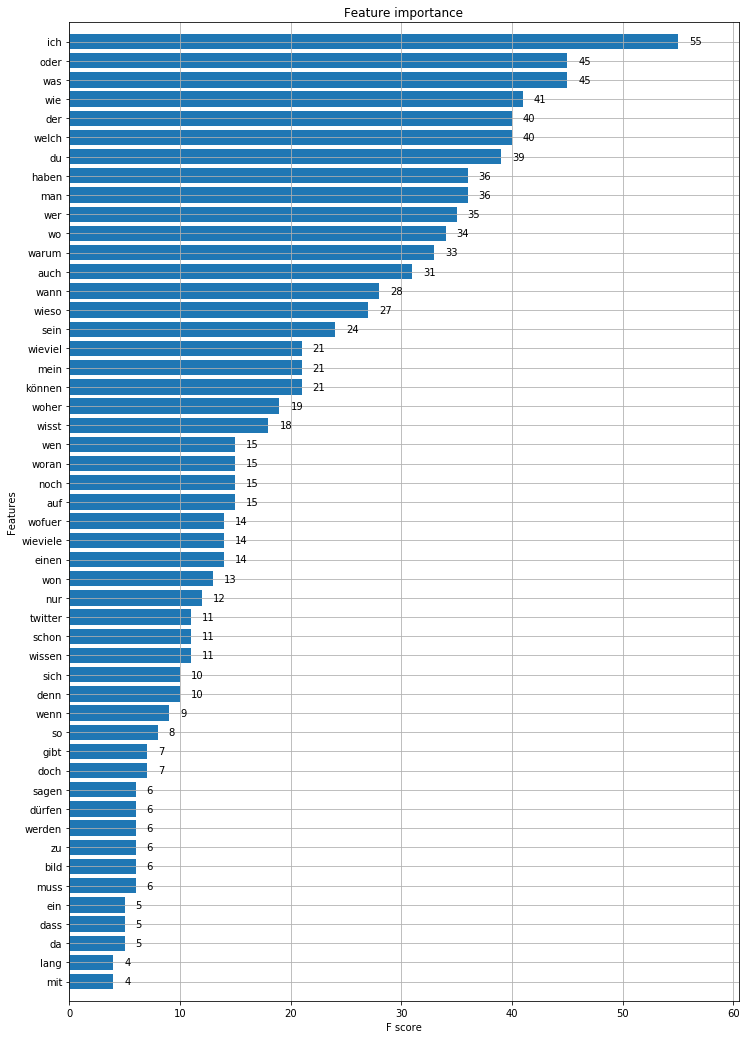

In [174]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xg_class_word, max_num_features=50, height=0.8, ax=ax)
plt.show()

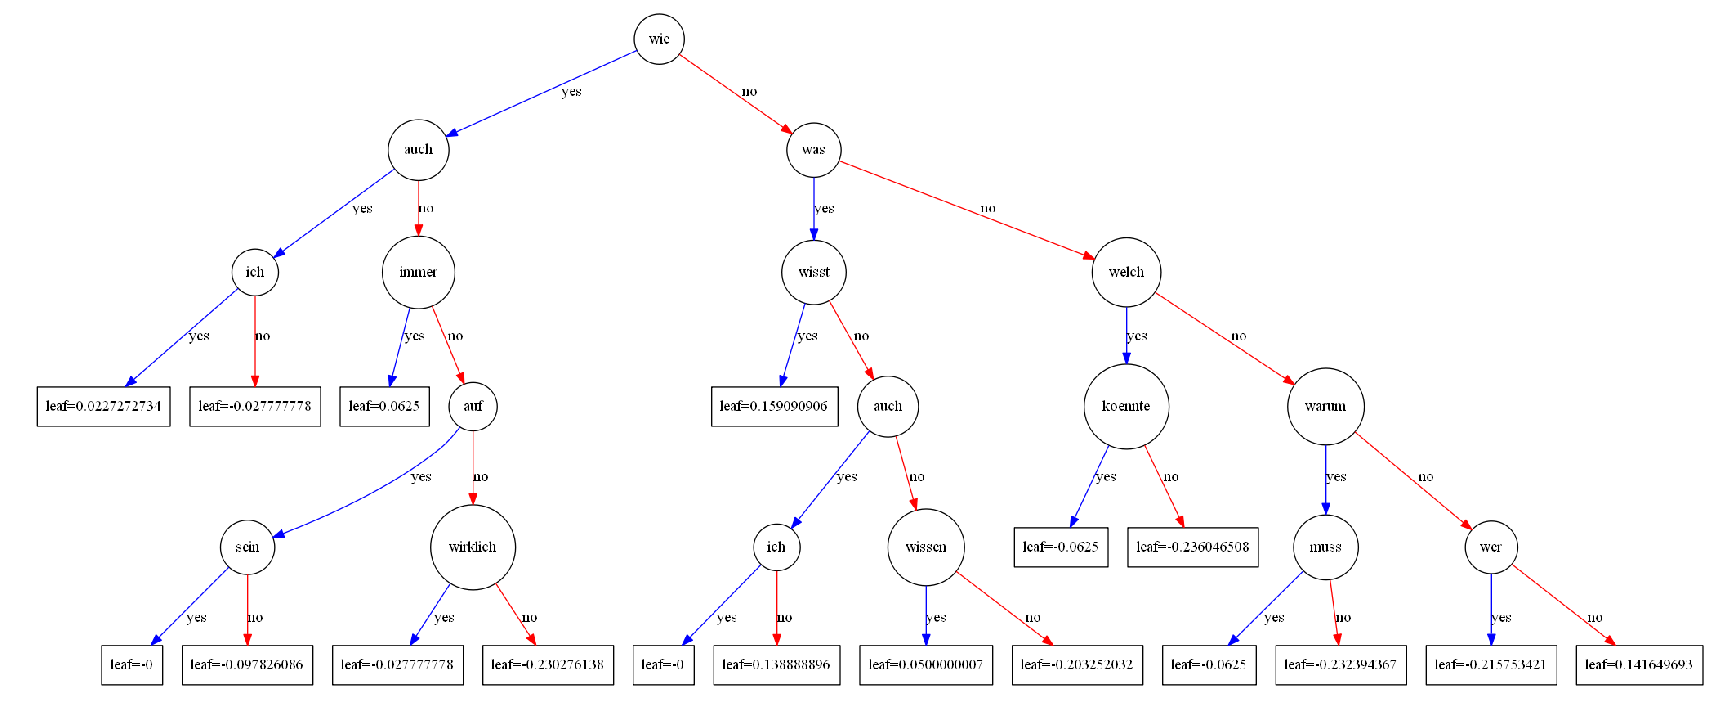

In [175]:
#fig, ax = plt.subplots(figsize=(30, 30))
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xg_class_word, ax=ax)
plt.show()

In [32]:
from sklearn.grid_search import GridSearchCV
#Choose all predictors except target & IDcols
param_test1 =  {
 'learning_rate':[0.125, 1.5],
 'n_estimators':[75, 100, 125],
 'max_depth': [4, 5, 6]}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      max_depth = 5,
                                                      random_state= 10,
                                                      min_child_weight = 1), 
param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.estimator.get_params()
gsearch1.fit(np.array(x_word_train), np.array(y_word_train))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.93938, std: 0.00479, params: {'learning_rate': 0.125, 'max_depth': 4, 'n_estimators': 75},
  mean: 0.94208, std: 0.00669, params: {'learning_rate': 0.125, 'max_depth': 4, 'n_estimators': 100},
  mean: 0.94207, std: 0.00706, params: {'learning_rate': 0.125, 'max_depth': 4, 'n_estimators': 125},
  mean: 0.94100, std: 0.00671, params: {'learning_rate': 0.125, 'max_depth': 5, 'n_estimators': 75},
  mean: 0.94261, std: 0.00805, params: {'learning_rate': 0.125, 'max_depth': 5, 'n_estimators': 100},
  mean: 0.94181, std: 0.00744, params: {'learning_rate': 0.125, 'max_depth': 5, 'n_estimators': 125},
  mean: 0.94235, std: 0.00632, params: {'learning_rate': 0.125, 'max_depth': 6, 'n_estimators': 75},
  mean: 0.94207, std: 0.00808, params: {'learning_rate': 0.125, 'max_depth': 6, 'n_estimators': 100},
  mean: 0.94153, std: 0.00774, params: {'learning_rate': 0.125, 'max_depth': 6, 'n_estimators': 125},
  mean: 0.92807, std: 0.00403, params: {'learning_rate': 1.5, 'max_depth': 4, 'n_esti

In [8]:


x, y = bag_frame_ngram.iloc[:,:-1],bag_frame_ngram.iloc[:,-1]

x_frame = pd.DataFrame(x[0].tolist(), columns = ngrams_bag)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_frame, y, test_size=0.2)#, random_state=20)

xg_class = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1, min_child_weight = 1, njobs=4)

In [ ]:
xg_class.fit(x_train, y_train)
preds = xg_class.predict(x_test)
accuracy_score(preds, y_test)

In [24]:
feature_set_ngram = [([(gram in ngrams(nltk.tokenize.WordPunctTokenizer().tokenize(data[0]), 2)) for gram in ngrams_bag], data[1]) for data in data_set]

16734

In [30]:
bag_frame_ngram = pd.DataFrame(feature_set_ngram)

x, y = bag_frame_ngram.iloc[:,:-1],bag_frame_ngram.iloc[:,-1]

x_frame = pd.DataFrame(x[0].tolist(), columns = ngrams_bag)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_frame, y, test_size=0.2)#, random_state=20)

xg_class = xgb.XGBClassifier(max_depth=7, n_estimators=400, learning_rate=0.1, min_child_weight = 1, njobs=4)

In [31]:
xg_class.fit(x_train, y_train)
preds = xg_class.predict(x_test)
accuracy_score(preds, y_test)

0.7487864077669902

In [131]:
bag_frame_encoded = pd.DataFrame(feature_set_words)

x, y = bag_frame_encoded.iloc[:,:-1],bag_frame_encoded.iloc[:,-1]

x_frame = pd.DataFrame(x[0].tolist(), columns = words_bag)

from sklearn.model_selection import train_test_split
accuracy = []
for i in range(15):
    xg_class = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.125, min_child_weight = 1, njobs=4)
    x_train, x_test, y_train, y_test = train_test_split(x_frame, y, test_size=0.2, random_state=i)
    xg_class.fit(x_train, y_train)
    preds = xg_class.predict(x_test)
    accuracy.append(accuracy_score(preds, y_test))

In [17]:
sum(accuracy) / len(accuracy)

0.9448986374210702

In [51]:
from sklearn.grid_search import GridSearchCV
#Choose all predictors except target & IDcols
param_test1 =  {
 'learning_rate':[0.05, 0.1, 0.15],
 'n_estimators':[75, 100, 125],
 'max_depth': [6, 7],
 'min_child_weight': [1, 2]}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      max_depth = 5,
                                                      random_state= 10,
                                                      min_child_weight = 1), 
param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.estimator.get_params()
gsearch1.fit(np.array(x_train), np.array(y_train))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.90538, std: 0.01378, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 75},
  mean: 0.91916, std: 0.01229, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100},
  mean: 0.92754, std: 0.00719, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 125},
  mean: 0.89759, std: 0.01819, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 75},
  mean: 0.89878, std: 0.01811, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100},
  mean: 0.89878, std: 0.01719, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 125},
  mean: 0.91436, std: 0.01087, params: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 75},
  mean: 0.92694, std: 0.00902, params: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100},
  mean: 0.9

In [134]:
test['Pred']=preds

In [108]:
depth = [3,5, 10]
esti = [50, 100, 300, 1000]
learning_rate = [0.05, 0.2, 0.4]

for d in depth:
    for e in esti:
        for l in learning_rate:
            xg_class = xgb.XGBClassifier(max_depth=d, n_estimators=e, learning_rate=l)
            xg_class.fit(x_train, y_train)
            preds = xg_class.predict(x_test)
            print('Depth:', d, 'Estimators:', e, 'Learning Rate:', l, 'Accuracy', accuracy_score(preds, y_test))

In [145]:
len(preds)*937799043062201

392000000000000018

In [150]:
wrong = [(index, test['Pred'][index])  for index in test.index if test[1][index] != test['Pred'][index]]

In [157]:
wrong_2 = [(index, test['Pred'][index])  for index in test.index if test[1][index] != test['Pred'][index]]

In [161]:
len(wrong_2)

34

In [153]:
for i, pred in wrong:
    print(i, data_set[i], 'pred:', pred)

678 ['hey crew, was empfehlt ihr in sachen kamera- und videoschnitt-apps auf android?', '0'] pred: 1
1663 ['ist das so einer, wo man nur am griff drehen muss?', '1'] pred: 0
209 ['was müsst ihr machen?', '0'] pred: 1
327 ['help, worum gehts hier eigentlich?', '0'] pred: 1
1888 ['um wieviele packungen handelt es sich bei diesem angebot?', '0'] pred: 1
1188 ['wisst ihr warum deutschland keine bananenrepublik ist?', '1'] pred: 0
108 ['war er jetzt da oder kam er zu spät?', '0'] pred: 1
1241 ['vollkornbrot, mehrkornbrot, sonnenblumenkernbrot, mohnbrot oder normales brot?', '0'] pred: 1
235 ['woran liegt das?', '0'] pred: 1
427 ['weißt du aber, was der gemacht hat?', '1'] pred: 0
1556 ['hat jemand welche?', '1'] pred: 0
682 ['seh ich aus wie ein auto?', '1'] pred: 0
1164 ['was wünscht ihr euch vor 20.00uhr?', '0'] pred: 1
1586 ['wieviele messungen kann dieses gerät speichern?', '0'] pred: 1
911 ['was geschieht bei euch in der region, wovon wir nichts mitbekommen?', '0'] pred: 1
856 ['weiß j